<a href="https://colab.research.google.com/github/maikejulie/DNN4Cli/blob/main/THOR/LRPonECCO/LRP_ECCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LRP ECCO

Sonnewald and Lguensat et al. 2021

### Import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import xarray as xr
from sklearn.preprocessing import StandardScaler

this custom colormap will be helpful

In [ ]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
mycmap = ListedColormap(['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red'])

Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive

/gdrive


# Ensemble MLPs

In [ ]:
!pip uninstall keras -y

Found existing installation: keras 2.6.0
Uninstalling keras-2.6.0:
  Successfully uninstalled keras-2.6.0


In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 5.1 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.4 which is incompatible.


In [ ]:
!pip install git+https://github.com/albermax/innvestigate.git@updates_towards_tf2.0

  Cloning https://github.com/albermax/innvestigate.git (to revision updates_towards_tf2.0) to /tmp/pip-req-build-_9oal1d5
  Running command git clone -q https://github.com/albermax/innvestigate.git /tmp/pip-req-build-_9oal1d5
  Running command git checkout -b updates_towards_tf2.0 --track origin/updates_towards_tf2.0
  Switched to a new branch 'updates_towards_tf2.0'
  Branch 'updates_towards_tf2.0' set up to track remote branch 'updates_towards_tf2.0' from 'origin'.
     |████████████████████████████████| 421.8 MB 16 kB/s 
     |████████████████████████████████| 3.8 MB 42.9 MB/s 
     |████████████████████████████████| 448 kB 36.1 MB/s 
  Created wheel for innvestigate: filename=innvestigate-2.0.0-py3-none-any.whl size=103615 sha256=c9d61380d0c6d1dab99e513b0da4480af92fa6ade5ccc72b042356bcbd06f2e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3ho3oar/wheels/99/56/02/c68d46873c61b27d2b31d62100a696ca4cb4c3390232795db7
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl si

In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import innvestigate.utils as iutils
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRPEpsilon

In [ ]:
TotalDataset = np.load('My Drive/colabwithMaike/closeThebudget/predictionfiles/TotalDatasetECCO.npy')
missingdataindex = np.load('My Drive/colabwithMaike/closeThebudget/predictionfiles/MissdataECCO.npy')

In [ ]:
from pickle import load
#######!!!!!! it might ask you to use scikit-learn 0.22.2.post1 !!!!!! check if you get the good .mean_ and .scale_
#(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
#         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
# array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
#        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))
scaler = load(open('My Drive/colabwithMaike/closeThebudget/scaler_v2.pkl', 'rb'))
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [ ]:
LRP_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],8))

for i in range(50):
  print(i)
  I1 = Input(shape=(8,)) 
  h1 = Dense(24, activation='tanh')(I1)
  h1 = Dense(24, activation='tanh')(h1)
  h1 = Dense(16, activation='tanh')(h1)
  h1 = Dense(16, activation='tanh')(h1)
  Output = Dense(6, activation='softmax')(h1)
  vanillamodel = Model(I1, Output)
  vanillamodel.load_weights('My Drive/colabwithMaike/closeThebudget/ManyNN/vanillamodel_'+str(i)+'.h5')
  #####
  model_wo_softmax = iutils.keras.graph.model_wo_softmax(vanillamodel)
  LRP_analyzer = LRPEpsilon(model_wo_softmax)
  analysisLRP = LRP_analyzer.analyze(scaler.transform(TotalDataset))
  analysisLRP.keys()
  ####
  LRP_ensemble[i,...] = analysisLRP[list(analysisLRP.keys())[0]]

In [ ]:
LRP_ensemble_scaled = LRP_ensemble/np.max(np.abs(LRP_ensemble),axis=2, keepdims=True)

In [ ]:
analysisLRPmean = np.mean(LRP_ensemble_scaled,0) #####MEAN

In [ ]:
sizeflat = 360,720

In [ ]:
analysiscurlTau = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysiscurlTau[~missingdataindex.flatten()] = analysisLRPmean[:,0]#/np.max(np.abs(analysisLRP[:,0]))

analysisSSH20mean = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisSSH20mean[~missingdataindex.flatten()] = analysisLRPmean[:,1]#/np.max(np.abs(analysisLRP[:,1]))

analysisgradxSSH = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisgradxSSH[~missingdataindex.flatten()] = analysisLRPmean[:,2]#/np.max(np.abs(analysisLRP[:,2]))

analysisgradySSH = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisgradySSH[~missingdataindex.flatten()] = analysisLRPmean[:,3]#/np.max(np.abs(analysisLRP[:,3]))

analysisbathm = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisbathm[~missingdataindex.flatten()] = analysisLRPmean[:,4]#/np.max(np.abs(analysisLRP[:,4]))

analysisgradxbathm = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisgradxbathm[~missingdataindex.flatten()] = analysisLRPmean[:,5]#/np.max(np.abs(analysisLRP[:,5]))

analysisgradybathm = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisgradybathm[~missingdataindex.flatten()] = analysisLRPmean[:,6]#/np.max(np.abs(analysisLRP[:,6]))

analysisF = np.nan * np.zeros((sizeflat[0]*sizeflat[1]))
analysisF[~missingdataindex.flatten()] = analysisLRPmean[:,7]#/np.max(np.abs(analysisLRP[:,7]))

Text(0.5, 1.0, 'F')

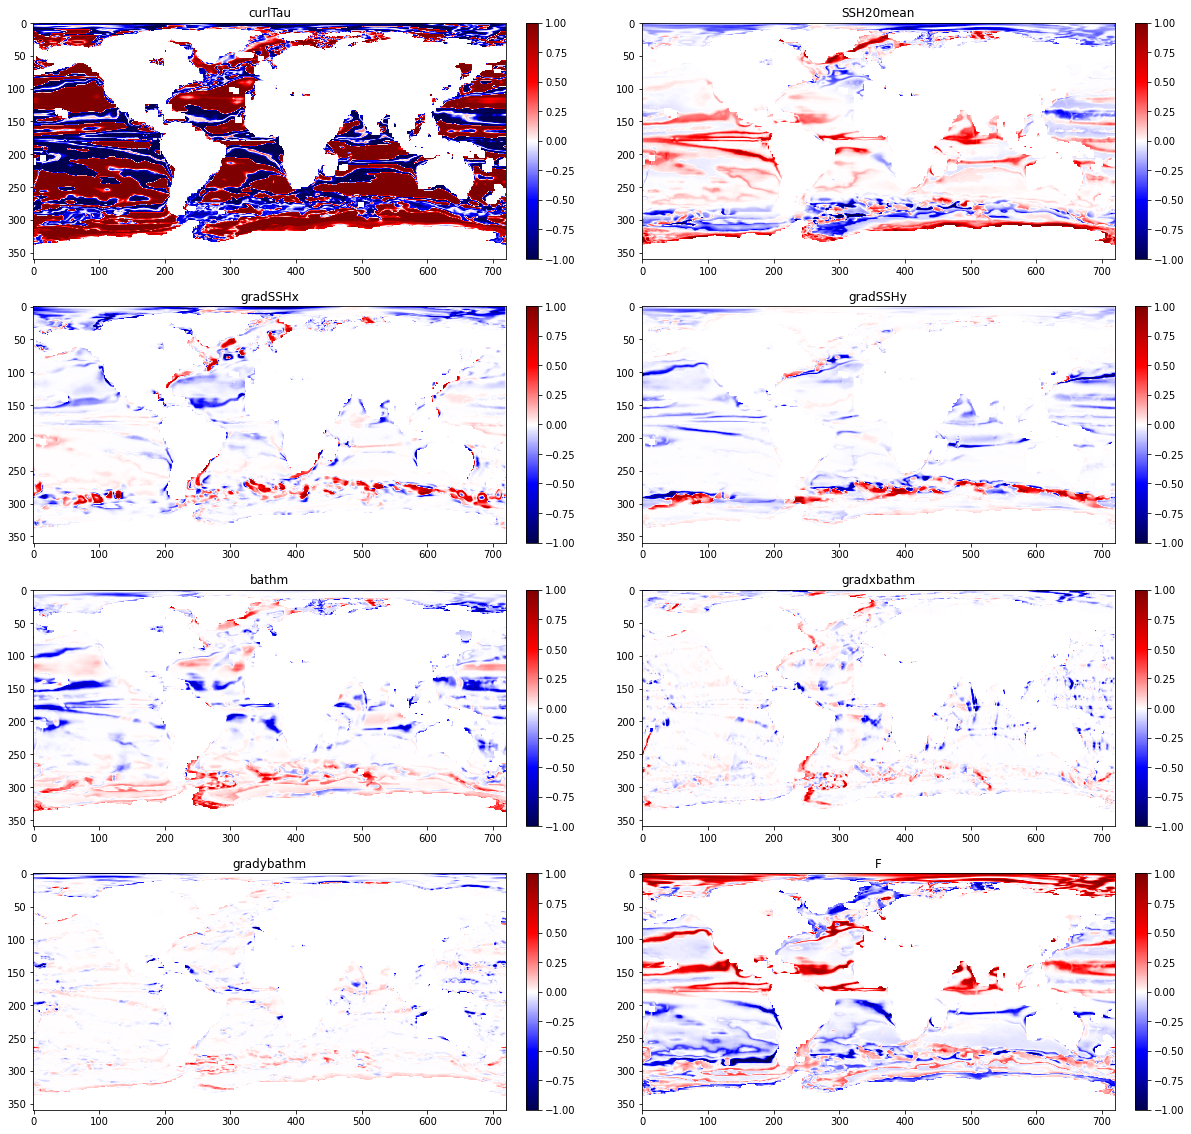

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(4,2,1)
plt.imshow(np.reshape(analysiscurlTau,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('curlTau')

plt.subplot(4,2,2)
plt.imshow(np.reshape(analysisSSH20mean,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('SSH20mean')

plt.subplot(4,2,3)
plt.imshow(np.reshape(analysisgradxSSH,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('gradSSHx')

plt.subplot(4,2,4)
plt.imshow(np.reshape(analysisgradySSH,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('gradSSHy')

plt.subplot(4,2,5)
plt.imshow(np.reshape(analysisbathm,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('bathm')

plt.subplot(4,2,6)
plt.imshow(np.reshape(analysisgradxbathm,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('gradxbathm')

plt.subplot(4,2,7)
plt.imshow(np.reshape(analysisgradybathm,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('gradybathm')

plt.subplot(4,2,8)
plt.imshow(np.reshape(analysisF,sizeflat)[::-1,:], cmap='seismic')
plt.colorbar(fraction=0.024, pad=0.04)
plt.clim(-1,1)
plt.title('F')

#plt.subplot(1,2,2)
#plt.imshow(ecco_label_mask[::-1,:], cmap=mycmap)
#plt.colorbar(fraction=0.024, pad=0.04)
#plt.title('Ground truth')

In [ ]:
PosNegRelevances = np.stack((np.reshape(analysiscurlTau,sizeflat),
          np.reshape(analysisSSH20mean,sizeflat),
          np.reshape(analysisgradxSSH,sizeflat),
          np.reshape(analysisgradySSH,sizeflat),
          np.reshape(analysisbathm,sizeflat),
          np.reshape(analysisgradxbathm,sizeflat),
          np.reshape(analysisgradybathm,sizeflat),
          np.reshape(analysisF,sizeflat)
          ))

In [ ]:
########CHANGE analysisLRPmean = np.mean(LRP_ensemble_scaled,0) to std if you want to save also stds #####MEAN

#StdRelevances = np.stack((np.reshape(analysiscurlTau,sizeflat),
#          np.reshape(analysisSSH20mean,sizeflat),
#          np.reshape(analysisgradxSSH,sizeflat),
#          np.reshape(analysisgradySSH,sizeflat),
#          np.reshape(analysisbathm,sizeflat),
#          np.reshape(analysisgradxbathm,sizeflat),
#          np.reshape(analysisgradybathm,sizeflat),
#          np.reshape(analysisF,sizeflat)
#          ))

In [ ]:
np.save('My Drive/colabwithMaike/closeThebudget/predictionfiles/PosNegRelevancesLRP_ECCO.npy',PosNegRelevances)
#np.save('My Drive/colabwithMaike/closeThebudget/STDRelevances_finalVersion.npy',StdRelevances)